# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
re = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.float_format', '{:.2f}'.format)
re.info()
re.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00
5,10,2890000.00,30.40,2018-09-10T00:00:00,1,NaN,12.00,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.00
6,6,3700000.00,37.30,2017-11-02T00:00:00,1,NaN,26.00,10.60,6,NaN,...,14.40,1.00,посёлок Парголово,52996.00,19143.00,0.00,NaN,0.00,NaN,155.00
7,5,7915000.00,71.60,2019-04-18T00:00:00,2,NaN,24.00,NaN,22,NaN,...,18.90,2.00,Санкт-Петербург,23982.00,11634.00,0.00,NaN,0.00,NaN,NaN
8,20,2900000.00,33.16,2018-05-23T00:00:00,1,NaN,27.00,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.00
9,18,5400000.00,61.00,2017-02-26T00:00:00,3,2.50,9.00,43.60,7,NaN,...,6.50,2.00,Санкт-Петербург,50898.00,15008.00,0.00,NaN,0.00,NaN,289.00


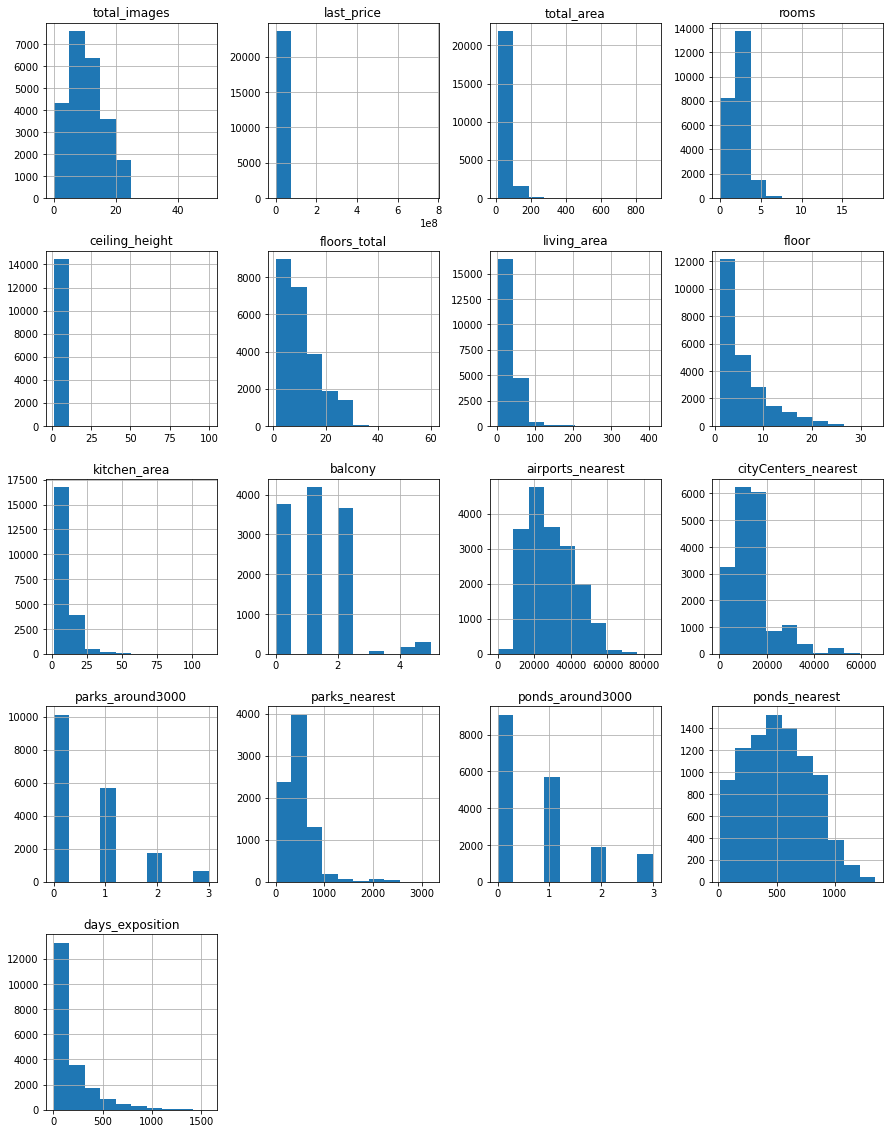

In [ ]:
re.hist(figsize=(15, 20));

### Выполните предобработку данных

Большая часть столбцов таблицы имеет пропуски, есть столбцы с некорректными типами данных. Всего записей: 23699

<b>2.1 Возможные причины возникновения пропусков данных:</b>
1. Некоторые хар-ки квартиры могут быть необязательными при заполнении объявления, поэтому их могут не заполнять.
2. Некоторые данные могут быть утеряны или не собраны в первоисточнике.
3. Некоторые пропуски могут являться систематическими, возникающими из-за особенностей базы данных или алгоритмов сбора информации (полученные автоматически на основе картографических данных, геосервисов и других централизвованных источников информации).

In [ ]:
re['last_price'] = re['last_price'].astype(int)
# замена дробного на целое (цена на момент снятия с публикации)

re['ceiling_height'] = re['ceiling_height'].fillna(re['ceiling_height'].median())
# замена Nan на медианное по столбцу (высота потолков м)

re['is_apartment'] = re['is_apartment'].astype(bool)
# изменение типа данных с object на bool

re['first_day_exposition'] = pd.to_datetime(re['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# изменение типа данных с object на datetime

re['balcony'] = re['balcony'].fillna(0).astype(int)
# замена Nan на 0 (количество балконов), замена дробного на целое

# re['rooms'].unique() # по моему мнению в столбце число комнат не может равнятся 0, как минимум должна быть одна.
# array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

re.loc[re['rooms'] == 0, 'rooms'] = 1
# замена числа комнат = 0 на = 1

re['floors_total'] = re['floors_total'].fillna(re['floor']).astype(int)
# замена Nan на 0, замена дробного на целое

#re.info()

<b>2.2 Изменение типов данных:</b>

1. last_price   /замена дробного на целое/   целочисленный тип данных (int) более удобен для визуализации данных, построения графиков и анализа, а так же лучше подходит для арифметических операций, без риска потери точности при округлении.

2. first_day_exposition   /изменение типа данных с object на datetime/   формат datetime даёт возможность выполнять операции с датами, такие как арифметические действия, сравнение дат, фильтрацию данных по временным диапазонам и т.д.

3. is_apartment   /изменение типа данных с object на bool/   согласно условиям проекта - столбец 'is_apartment' апартаменты (булев тип).

4. balcony   /замена дробного на целое/   1.5 балкона, возможно самострой.

5. floors_total   /замена дробного на целое/ целочисленные этажи в целочисленных домах.

<b>2.3 Работа с дубликатами</b>

In [ ]:
#re['locality_name'].sort_values().unique()
#len(re['locality_name'].unique()) # до очистки 365 записей

re['cleaned_locality_name'] = ( # новый столбец с очищенными данными
    re['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа', 'поселок при железнодорожной станции', 'городской поселок'], 'поселок', regex=True)
    .replace(['садоводческое некоммерческое товарищество'], 'садовое товарищество', regex=True)
) 

#re['cleaned_locality_name'].sort_values().unique()
#len(re['cleaned_locality_name'].unique()) # после 323 записи

### Добавьте в таблицу новые столбцы

In [ ]:
re['price_m2'] = (re['last_price'] / re['total_area']).round(2) 
# цена одного квадратного метра (новый столбец)

re['day'] = re['first_day_exposition'].dt.weekday 
# номер дня недели публикации объявления (новый столбец)
re['month'] = re['first_day_exposition'].dt.month 
# месяц публикации объявления (новый столбец)
re['year'] = re['first_day_exposition'].dt.year 
# год публикации объявления (новый столбец)

re['first_floor'] = (re['floor'] == 1) *1 
# первый этаж (новый столбец)
re['last_floor'] = (re['floor'] == re['floors_total']) *1 
# последний этаж (новый столбец)

re['floor_type'] = 'другой' 
# установка всех значений столбца 'floor_type' на 'другой' 
re.loc[re['first_floor'] == 1, 'floor_type'] = 'первый' 
# установка значений 'первый' для первого этажа 
re.loc[re['last_floor'] == 1, 'floor_type'] = 'последний' 
# установка значений 'последний' для последнего этажа 

#re['cityCenters_km'] = (re['cityCenters_nearest'] / 1000).round().fillna(100000).astype(int)

re['cityCenters_km'] = (re['cityCenters_nearest'] / 1000)
re['cityCenters_km'] = np.floor(pd.to_numeric(re['cityCenters_km'], errors='coerce')).astype('Int64')
# расстояние до центра города в километрах (новый столбец)

#re['cityCenters_km'].head(30)
#re.info()

### Проведите исследовательский анализ данных

<b>4.1 Изучение параметров объектов и постройка гистограмм </b>

count   23699.00
mean       60.00
std        36.00
min        12.00
25%        40.00
50%        52.00
75%        70.00
max       900.00
Name: total_area, dtype: float64

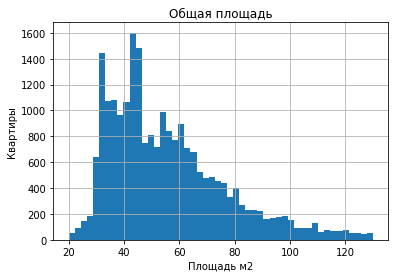

In [ ]:
#xy = re['total_area'].plot(kind='hist', bins=50, range=(10,150), grid=True, title='Общая площадь')

filtered_total_area = re[(re['total_area'] > 20) & (re['total_area'] <= 130)]['total_area']

xy = re['total_area'].plot(kind='hist', bins=50, range=(20,130), grid=True, title='Общая площадь')

xy.set_xlabel('Площадь м2')
xy.set_ylabel('Квартиры')
re['total_area'].describe().round()

Общая площадь в выборке имеет значения от 12 до 900 м2, среднее значение 60, а медиана 52 м2. Данные имеют нормальное распределение.

count   21796.00
mean       34.00
std        22.00
min         2.00
25%        19.00
50%        30.00
75%        42.00
max       410.00
Name: living_area, dtype: float64

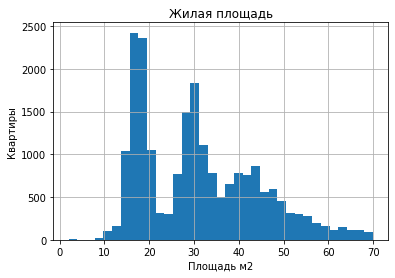

In [ ]:
xy = re['living_area'].plot(kind='hist', bins=35, range=(2,70), grid=True, title='Жилая площадь')
xy.set_xlabel('Площадь м2')
xy.set_ylabel('Квартиры')
re['living_area'].describe().round()

Жилая площадь в выборке имеет значения от 2 до 410 м2, среднее значение 34, а медиана 30 м2. На основе этих данных можно сказать, что распределение жилой площади квартир имеет средне-крупные значения, с достаточно большим разбросом относительно среднего значения, что указывает на наличие как небольших квартир, так и крупных помещений в данных.

count   21421.00
mean       11.00
std         6.00
min         1.00
25%         7.00
50%         9.00
75%        12.00
max       112.00
Name: kitchen_area, dtype: float64

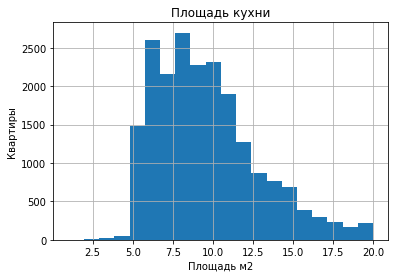

In [ ]:
xy = re['kitchen_area'].plot(kind='hist', bins=20, range=(1,20), grid=True, title='Площадь кухни')
xy.set_xlabel('Площадь м2')
xy.set_ylabel('Квартиры')
re['kitchen_area'].describe().round()

Площадь кухни в выборке имеет значения от 1 до 112 м2, среднее значение 11, а медиана 9 м2. Наблюдается большая вариативность площади кухонь, что видно из довольно большого стандартного отклонения и разницы между минимальным и максимальным значениями.

count   23699.00
mean        6.54
std        10.89
min         0.01
25%         3.40
50%         4.65
75%         6.80
max       763.00
Name: last_price, dtype: float64

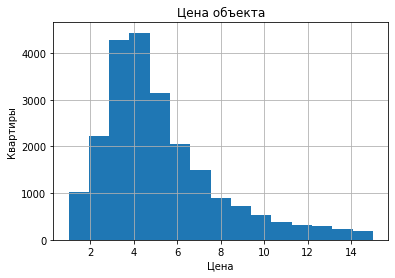

In [ ]:
#xy = (re['last_price'] / 1000000).plot(kind='hist', bins=20, range=(0,20), grid=True, title='Цена объекта')
   
filtered_last_price = re[(re['last_price'] > 1000000) & (re['last_price'] <= 15000000)]['last_price']

xy = (filtered_last_price / 1000000).plot(kind='hist', bins=15, range=(1,15), grid=True, title='Цена объекта')

xy.set_xlabel('Цена')
xy.set_ylabel('Квартиры')
(re['last_price'] /1000000).describe()

Цена объекта в выборке имеет значения от 12190 тысяч до 763 млн., среднее значение 6.54 млн., а медиана 4.65 млн. Исходя из этих данных, можно сказать, что распределение цен продажи квартир имеет существенный разброс, начиная от минимальной цены до очень высоких значений, что видно из большого стандартного отклонения и разницы между минимальным и максимальным значениями. Минимальное значение цены объекта в 12190 тысячи скорее всего являет ошибкой.

count   23699.00
mean        2.08
std         1.07
min         1.00
25%         1.00
50%         2.00
75%         3.00
max        19.00
Name: rooms, dtype: float64

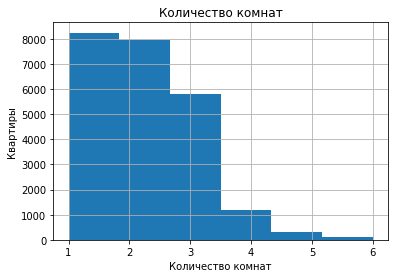

In [ ]:
#xy = re['rooms'].plot(kind='hist', bins=8, range=(1,8), grid=True, title='Количество комнат')

filtered_rooms = re[(re['rooms'] <= 6)]['rooms']

xy = filtered_rooms.plot(kind='hist', bins=6, range=(1,6), grid=True, title='Количество комнат')
xy.set_xlabel('Количество комнат')
xy.set_ylabel('Квартиры')
re['rooms'].describe()

#filtered_rooms.describe()
#re['rooms'].unique()

Количество комнат в квратирах имеет значение от 1 до 19. Больше всего однокомнатных квартир, возможно из-за замены квартир с 0 значением на 1.

count   23699.00
mean        2.72
std         0.99
min         1.00
25%         2.60
50%         2.65
75%         2.70
max       100.00
Name: ceiling_height, dtype: float64

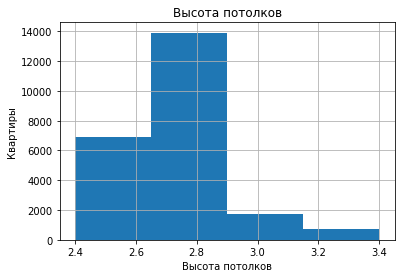

In [ ]:
#xy = re['ceiling_height'].plot(kind='hist', bins=10, range=(2.5,3.5), grid=True, title='Высота потолков')

filtered_ceiling_height = re[(re['ceiling_height'] > 2) & (re['ceiling_height'] <= 4)]['ceiling_height']

xy = filtered_ceiling_height.plot(kind='hist', bins=4, range=(2.4,3.4), grid=True, title='Высота потолков')

xy.set_xlabel('Высота потолков')
xy.set_ylabel('Квартиры')
re['ceiling_height'].describe()

#filtered_ceiling_height.describe()
#re['ceiling_height'].unique()

Высота потолков в выборке имеет значения от 1 до 100 м, среднее значение 2.72, а медиана 2.65 м. Все значения с пропусками в данном столбце были заменены на медианные, возможно это повлияло на распределение. Высота потолков 1 и 100 метров вызывают сомнения в достоверноести этих данных.

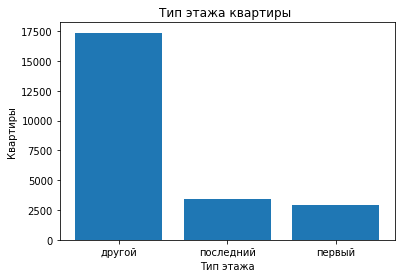

In [ ]:
floor_type = re['floor_type'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(floor_type.index, floor_type.values)
plt.title('Тип этажа квартиры ', fontsize=12)
plt.xlabel('Тип этажа', fontsize=10)
plt.ylabel('Квартиры', fontsize=10)
plt.show()

Из этой выборки очевидно что квартир на первом и последнем этаже, гораздо меньше "промежуточных". Отсюда такое распредление в объявлениях.

count   23699.00
mean       11.00
std         7.00
min         1.00
25%         5.00
50%         9.00
75%        16.00
max        60.00
Name: floors_total, dtype: float64

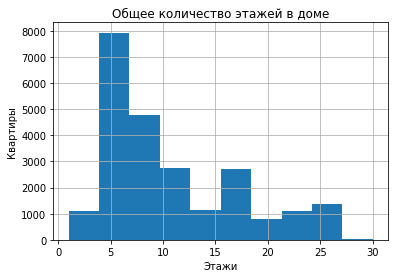

In [ ]:
xy = re['floors_total'].plot(kind='hist', bins=10, range=(1,30), grid=True, title='Общее количество этажей в доме')
xy.set_xlabel('Этажи')
xy.set_ylabel('Квартиры')
re['floors_total'].describe().round()

Исходя из этих данных, можно сказать, что распределение количества этажей в доме имеет средние значения 11 этажей. Присутствуют как одноэтажные дома , так и многоэтажки (значение > 15). Также видно, что большинство квартир продаются в домах с диапазоном этажей от 5 до 16.

count   18180.00
mean    14191.00
std      8608.00
min       181.00
25%      9238.00
50%     13098.00
75%     16293.00
max     65968.00
Name: cityCenters_nearest, dtype: float64

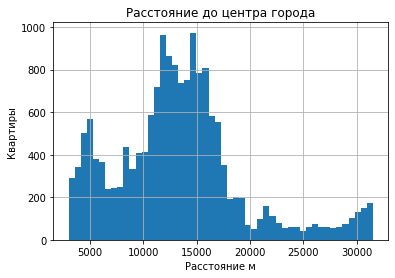

In [ ]:
xy = re['cityCenters_nearest'].plot(kind='hist', bins=50, range=(3000,31500), grid=True, title='Расстояние до центра города')
xy.set_xlabel('Расстояние м')
xy.set_ylabel('Квартиры')
re['cityCenters_nearest'].describe().round()

In [ ]:
re['cityCenters_nearest'].quantile(0.05), re['cityCenters_nearest'].quantile(0.95)

(3541.0, 31671.599999999977)

Расстояние до центра города в выборке имеет значения от 181 до 65968 м, среднее значение 14191, а медиана 13098 м. Основная часть квартир расположена в пределах 10-16 км от центра вероятно по нескольким причинам: центральные районы часто являются коммерческими и деловыми зонами, что повышает стоимость недвижимости в них, поэтому люди могут выбирать более доступные по цене варианты в более удаленных районах; расширение города может привести к тому, что новые районы за пределами центра предлагают более современные и комфортабельные жилые комплексы.

count   8079.00
mean     491.00
std      342.00
min        1.00
25%      288.00
50%      455.00
75%      612.00
max     3190.00
Name: parks_nearest, dtype: float64

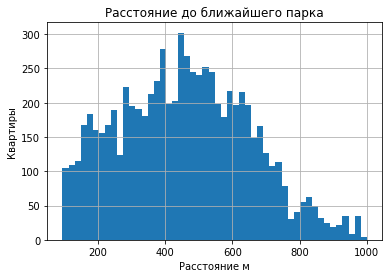

In [ ]:
xy = re['parks_nearest'].plot(kind='hist', bins=50, range=(95,1000), grid=True, title='Расстояние до ближайшего парка')
xy.set_xlabel('Расстояние м')
xy.set_ylabel('Квартиры')
re['parks_nearest'].describe().round()

In [ ]:
re['parks_nearest'].quantile(0.05), re['parks_nearest'].quantile(0.95)

(95.90000000000003, 968.0)

Расстояние до ближайшего парка в выборке имеет значения от 1 до 3190 м, среднее значение 491, а медиана 455 м. В целом, это говорит о том, что у нас в стране, в среднем, через каждые 500 метров по парку.

<b>4.2 Как быстро продавались квартиры?</b>

count   20518.00
mean      181.00
std       220.00
min         1.00
25%        45.00
50%        95.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: float64

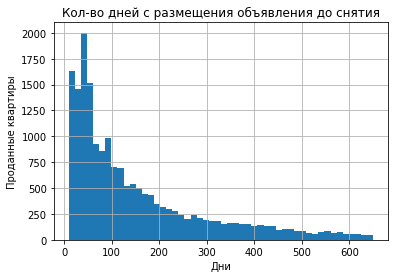

In [ ]:
xy = re['days_exposition'].plot(kind='hist', bins=50, range=(10,650), grid=True, title='Кол-во дней с размещения объявления до снятия')
xy.set_xlabel('Дни')
xy.set_ylabel('Проданные квартиры')
re['days_exposition'].describe().round()

In [ ]:
re['days_exposition'].mean(), re['days_exposition'].median()

(180.88863436982163, 95.0)

In [ ]:
re['days_exposition'].quantile(0.05), re['days_exposition'].quantile(0.95)

(9.0, 647.0)

Вывод: как видно из гистограммы - пик продаж приходится на интервал с 1 по 45 день от публикации объявления, в среднем (mean) квартиры продаются за 180 дней, по медиане за 95 дней. К быстрым продажам можно отнести квартиры, проданные в срок до 9 дней, а к необычно долгим, проданные в срок более 640 дней (возможно такие объявления просто не закрыли/ не сняли вовремя).

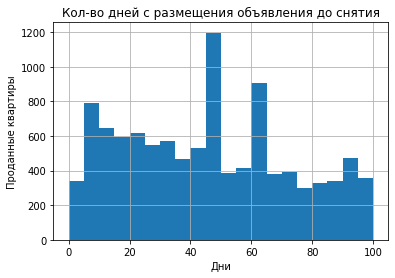

In [ ]:
xy = re['days_exposition'].plot(kind='hist', bins=20, range=(0,100), grid=True, title='Кол-во дней с размещения объявления до снятия')
xy.set_xlabel('Дни')
xy.set_ylabel('Проданные квартиры');

<b>4.3 Факторы, которые больше всего влияют на стоимость объекта.</b>

0.6536750579657242

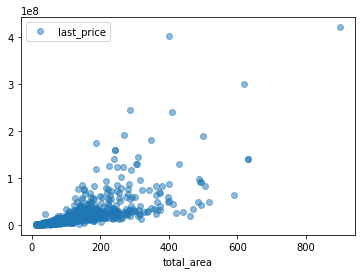

In [ ]:
total_area_price = re.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['median'])
total_area_price.plot(y = 'median', style = 'o', alpha=0.5)
re['total_area'].corr(re['last_price'])

Зависимость цены от общей площади квартиры 0.65, согласно коэффициента корреляции Пирсона, является высокой положительной. Т.е. с увеличением общей площади квартиры возрастает и её цена.

0.5664915336952651

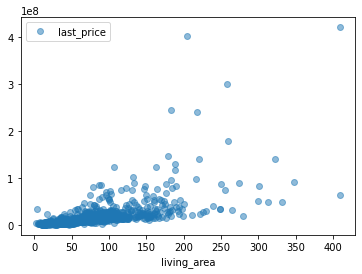

In [ ]:
living_area_price = re.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['median'])
living_area_price.plot(y = 'median', style = 'o', alpha=0.5)
re['living_area'].corr(re['last_price'])

Зависимость цены от жилой площади квартиры 0.56, согласно коэффициента корреляции Пирсона, является высокой положительной. Т.е. с увеличением жилой площади квартиры возрастает и её цена.

0.5198690130216392

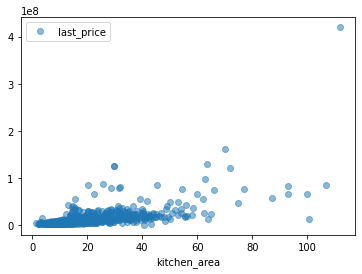

In [ ]:
kitchen_area_price = re.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['median'])
kitchen_area_price.plot(y = 'median', style = 'o', alpha=0.5)
re['kitchen_area'].corr(re['last_price'])

Зависимость цены от площади кухни 0.51, согласно коэффициента корреляции Пирсона, является высокой положительной. Т.е. с увеличением площади кухни квартиры возрастает и её цена.

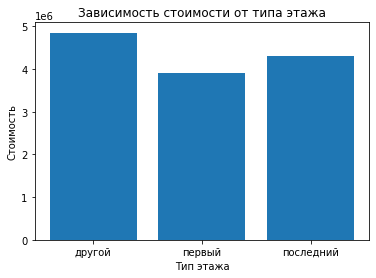

In [ ]:
price_by_floor = re.groupby('floor_type')['last_price'].median().reset_index()
plt.figure(figsize=(6, 4))
plt.bar(price_by_floor['floor_type'], price_by_floor['last_price'])
plt.xlabel('Тип этажа')
plt.ylabel('Cтоимость')
plt.title('Зависимость стоимости от типа этажа')
plt.show()

Из графика следует что квартиры на первом этаже стоят дешевле квартир на последнем и иных этажах. Самые дорогие квартиры в категории "другой".

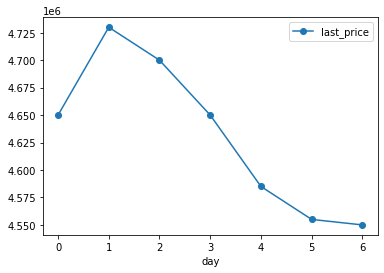

In [ ]:
day_price = re.pivot_table(index = 'day', values = 'last_price', aggfunc = ['median'])
day_price.plot(y = 'median', style = 'o-', alpha=1);

Изменения в дне публикации объявления практически не влияют на цену недвижимости. Из графика можно сделать вывод что, квартиры,  объявления о продаже которых разместили будние дни, имеют более высокую цену, чем квартиры с размещением в выходные.

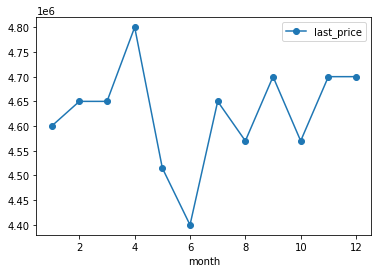

In [ ]:
month_price = re.pivot_table(index = 'month', values = 'last_price', aggfunc = ['median'])
month_price.plot(y = 'median', style = 'o-', alpha=1);

Месяц публикации объявления также практически не влияет на цену недвижимости. Из графика видно что в начале лета рынок "падает", вероятно это связано с началом отпусков и желанием владельцев побыстрее избавиться от недвижимости. 

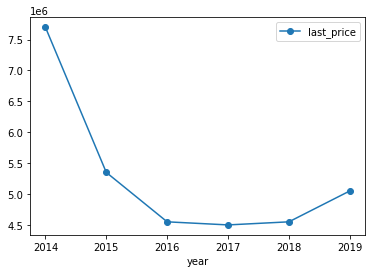

In [ ]:
year_price = re.pivot_table(index = 'year', values = 'last_price', aggfunc = ['median'])
year_price.plot(y = 'median', style = 'o-', alpha=1);

На графике отчетливо видно резкое падение стоимоисти недвижимости начиная с 2014 года (возможно из геополитических событий), и только к 2019 году начался рост. 

<b>4.4 Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.</b>

In [ ]:
top_10_localities = re['cleaned_locality_name'].value_counts().head(10)
# выборка топ-10 населенных пунктов по количеству объявлений

locality_price = re.pivot_table(index='cleaned_locality_name', values='price_m2')

top_10 = locality_price.join(top_10_localities, how='right')
# скадываем 2 DF — с данными о ценах за м2 по населенным пунктам, и с кол-вом объявлений по топ-10 населенным пунктов

top_10 = top_10.rename(columns={'price_m2': 'Цена за м2', 'cleaned_locality_name': 'Кол-во объявлений'})
top_10.sort_values(by='Цена за м2', ascending=False).round(2)

,Цена за м2,Кол-во объявлений
Санкт-Петербург,114849.01,15721
Пушкин,103125.82,369
деревня Кудрово,92473.55,299
поселок Парголово,90175.91,327
поселок Мурино,85681.76,556
поселок Шушары,78677.36,440
Колпино,75424.58,338
Гатчина,68746.15,307
Всеволожск,68654.47,398
Выборг,58141.91,237


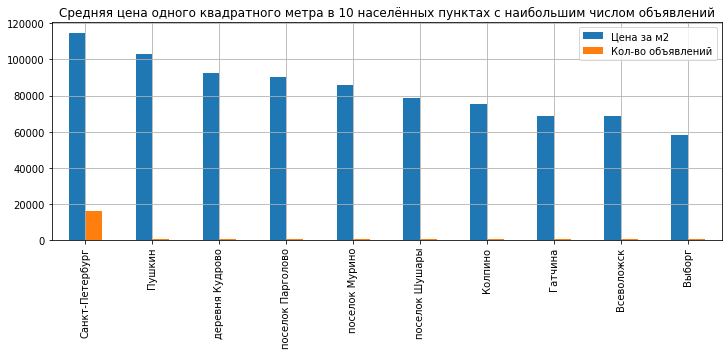

In [ ]:
top_10.sort_values(by=['Цена за м2'], ascending=False).plot(figsize=(12, 4), kind='bar', grid=True, title='Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений');

Из графика следует что, в Санкт-Петербурге самая высокая цена за м2 - 114849.01	, а Выборге, смамая низкая цена за м2 из выборки 10 населённных пунктов - 58141.91.

<b>4.5 Средняя стоимость квартиры в Санкт-Петербурге на разном удалении от центра.</b>

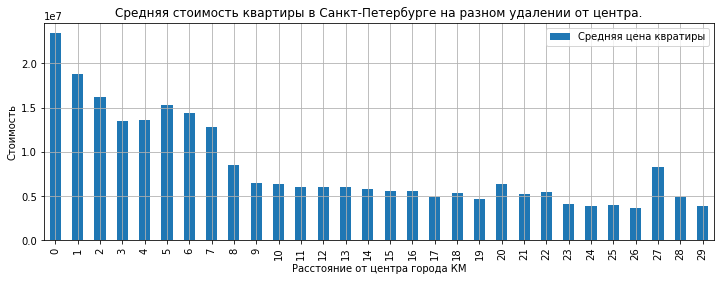

In [ ]:
mean_prices_spb = (
    re.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'cityCenters_km', values = 'last_price', aggfunc = 'mean'))
# фильтр для "Санкт-Петербург"

mean_prices_spb = mean_prices_spb.rename(columns={'last_price': 'Средняя цена квратиры'})
mean_prices_spb.plot(figsize=(12, 4), kind='bar', grid=True, title='Средняя стоимость квартиры в Санкт-Петербурге на разном удалении от центра.')
plt.xlabel('Расстояние от центра города КМ')
plt.ylabel('Cтоимость');

In [ ]:
mean_prices_spb.head(10)

,Средняя цена квратиры
cityCenters_km,
0,23442315.44
1,18850851.66
2,16163313.62
3,13436830.55
4,13632024.64
5,15306121.12
6,14389106.19
7,12797673.74
8,8445272.00


Самые дорогие квартиры находятся ближе к центру города, на расстоянии 8 км от центра города стоимость квартир начинает снижается.

### Напишите общий вывод

По итогам проведенного анализа данных в рамках данного проекта можно сделать следующие выводы:

1. После предварительного изучения и предобработки данных, включая заполнение пропущенных значений, установление корректного типа данных, удаление неявных дубликатов и обработку аномалий, данные подготовлены для дальнейшего анализа.

2. Были добавлены новые параметры для более детального исследования объявлений о продаже квартир, такие как цена за квадратный метр, день, месяц и год публикации объявления, тип этажа квартиры и расстояние до центра города.

3. Проведя анализ основных параметров квартир можно сделать следующие выводы: общая площадь квартир в выборке имеет нормальное распределение со средним значением 60 м2, цена квартиры из в выборки в среднем составляет 6.54 млн, больше всего квартир в выборке с одной и двумя комнатами, средняя высота потолков 2.65 метра. Большинство квартир на продажу находятся в промежутке между первым и последним этажей. Среднее количество этажей в доме составляет 11, преобладают многоэтажные дома. Большинство квартир расположено в радиусе 10-16 км от центра города. Расстояние до ближайшего парка в среднем составляет 491 м.

4. Исследов сроки продажи квартир, выявлено что, пик продаж квартир приходится на интервал с 1 по 45 день от публикации объявления, в среднем квартиры продаются за 180 дней. К быстрым продажам можно отнести квартиры, проданные в срок до 9 дней, а к необычно долгим, проданные в срок более 640 дней.

5. Изучив факторы, влияющие на общую стоимость объекта, можно сделать вывод, что самые значимые факторы это - общая площадь квартиры (чем больше площадь, тем выше цена), удаленность от центра (чем дальше от центра, тем ниже цена), жилая площадь и площадь кухни, а также тип этажа. Практически не оказывает влияние на стоимость квартиры время размещения объявления. 

6. Выявлены населенные пункты с наибольшим числом объявлений и с самой высокой и самой низкой стоимостью квадратного метра - это Санкт-Петербург цена за м2 - 114849.01 , и Выборг, смамая низкая цена за м2 - 58141.91.

7. Проанализировав зависимость цены квартиры в Санкт-Петербурге от расстояния до центра города, сделан вывод о том что - самые дорогие квартиры находятся ближе к центру города (самые дорогие в радиусе 3км),а на расстоянии 8 км от центра города стоимость квартир начинает снижается.